# MOXSI Spectra Broken Down by Ion Component

In [1]:
import sys
import pathlib
import copy

import ndcube
import numpy as np
import astropy.units as u
import fiasco
import matplotlib.colors
import matplotlib.pyplot as plt
from adjustText import adjust_text
import astropy.table
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, quantity_support
from sunpy.coordinates import get_earth, Helioprojective

from mocksipipeline.util import dem_table_to_ndcube
from mocksipipeline.spectral import calculate_intensity,get_spectral_tables
from mocksipipeline.detector import compute_flux_point_source
from mocksipipeline.detector.response import Channel, nominal_design

from synthesizAR.atomic.idl import compute_spectral_table, read_spectral_table

sys.path.append('/Users/wtbarnes/Documents/projects/cubixss/moxsi-science-planning/scripts/')
from generate_spectral_table import list_all_ions

In [22]:
def annotate_lines(axis, line_list, data_x, data_y, color, rtol=0.0):
    for row in line_list:
        if row['intensity_scaled (coronal)_active_region'] < rtol:
            continue
        i_x = np.argmin(np.fabs(data_x-row['wavelength']))
        axis.annotate(
            f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline", precision=5)}',
            (data_x[i_x].to_value(), data_y[i_x]),
            xytext=(0, 150),
            textcoords='offset points',
            rotation=90,
            color=color,
            horizontalalignment='center',
            verticalalignment='center',
            arrowprops=dict(color=color, arrowstyle='-', ls='--'),
        )

Parse line list

In [73]:
line_list = astropy.table.QTable.read('../data/line_lists/full-line-list.asdf')
line_list_reduced = line_list[line_list['wavelength']>0*u.AA]
# line_list_reduced = line_list_reduced[list(map(lambda x: x in ('Fe', 'Mg', 'Si', 'S'), line_list_reduced['element']))]
all_chianti_elements = [fiasco.Element(el, 1*u.MK) for el in fiasco.list_elements(fiasco.defaults['hdf5_dbase_root'])]
element_is_low_fip = {el.atomic_symbol: el[0].ip<=10*u.eV for el in all_chianti_elements}
line_list_reduced['is low FIP'] = list(map(lambda x: element_is_low_fip[x], line_list_reduced['element']))

Parse DEM tables

In [4]:
chianti_dir = '/Users/wtbarnes/ssw/packages/chianti/dbase/'
dem_flare_ext = dem_table_to_ndcube(fiasco.io.Parser('flare_ext.dem', ascii_dbase_root=chianti_dir).parse())
dem_ar = dem_table_to_ndcube(fiasco.io.Parser('active_region.dem', ascii_dbase_root=chianti_dir).parse())

Parse abundance table for Feldman coronal abundances

In [5]:
abundance_table = fiasco.io.Parser('/Users/wtbarnes/ssw/packages/chianti/dbase/abundance/sun_coronal_1992_feldman_ext.abund',
                                   standalone=True).parse()

Build spectra for each individual ion weighted by coronal abundances

In [6]:
spec_tables = get_spectral_tables()

In [7]:
spectra = {}
for key,tab in spec_tables.items():
    key_split = key.split('_')
    if key_split[0] != 'unity':
        continue
    _, element_name, ionization = key_split 
    abund = abundance_table[abundance_table['element']==tab.meta['ion_list'][0].split('_')[0].capitalize()]['abundance']
    spectra[f'{element_name}_{ionization}'] = tab * abund 
# Add the dielectronic ion components to the regular one and remove the dielectronic component
dielectronic_keys = []
for k,v in spectra.items():
    el,ionization = k.split('_')
    if 'd' in ionization:
        spectra[f'{el}_{ionization[:-1]}'] += v.data*v.unit
        dielectronic_keys.append(k)
for dk in dielectronic_keys:
    del spectra[dk]
spectra = dict(sorted(spectra.items(), key=lambda x: (x[0].split('_')[0], int(x[0].split('_')[1]))))

Double check that only the continuum is left over when subtracting the total from the component-wise sum

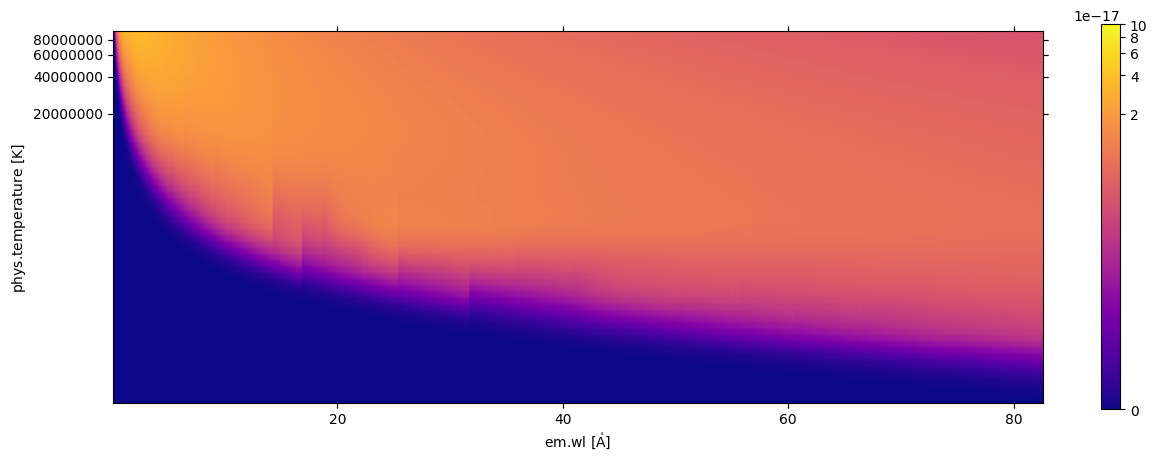

In [8]:
spec_total = 0*spectra['fe_9']
for k in spectra:
    spec_total = spec_total + spectra[k].data*spectra[k].unit
spec_diff = spec_tables['sun_coronal_1992_feldman_ext_all'] - spec_total.data*spec_total.unit
spec_diff = spec_diff[:,:1500]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=spec_diff.wcs)
spec_diff.plot(aspect=10,axes=ax,norm=ImageNormalize(vmax=1e-16,stretch=LogStretch()), cmap='plasma')
fig.colorbar(ax.get_images()[0])

Also compute the spectra explicitly using the list of all ions

Calculate intensities for flare and AR cases

In [9]:
intensities_ar = {k: calculate_intensity(dem_ar, v, {}) for k,v in spectra.items()}
intensities_flare = {k: calculate_intensity(dem_flare_ext, v, {}) for k,v in spectra.items()}

Now, map intensities to detector locations, assuming a point source

In [10]:
earth_observer = get_earth(time='2020-01-01 12:00:00')

In [11]:
source_location = SkyCoord(Tx=0*u.arcsec,
                           Ty=0*u.arcsec,
                           frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

In [12]:
channel = Channel('spectrogram_1', order=1,)
blur = 40 * u.arcsec / channel.spatial_plate_scale[0] * channel.spectral_plate_scale

In [13]:
flux_ar = {k: compute_flux_point_source(v,
                                        source_location,
                                        blur=blur, 
                                        electrons=True,
                                        include_gain=True,
                                        channels=[channel])
           for k,v in intensities_ar.items()}

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backend

In [16]:
flux_flare = {k: compute_flux_point_source(v, source_location, ) for k,v in intensities_flare.items()}

KeyboardInterrupt: 

In [14]:
flux_ar_total = compute_flux_point_source(
    calculate_intensity(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], {}),
    source_location,
    blur=blur,
    electrons=True,
    include_gain=True,
    channels=[channel],
)

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_67718/780344975.py:14: RuntimeWarning: invalid value encountered in divide
  ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range]


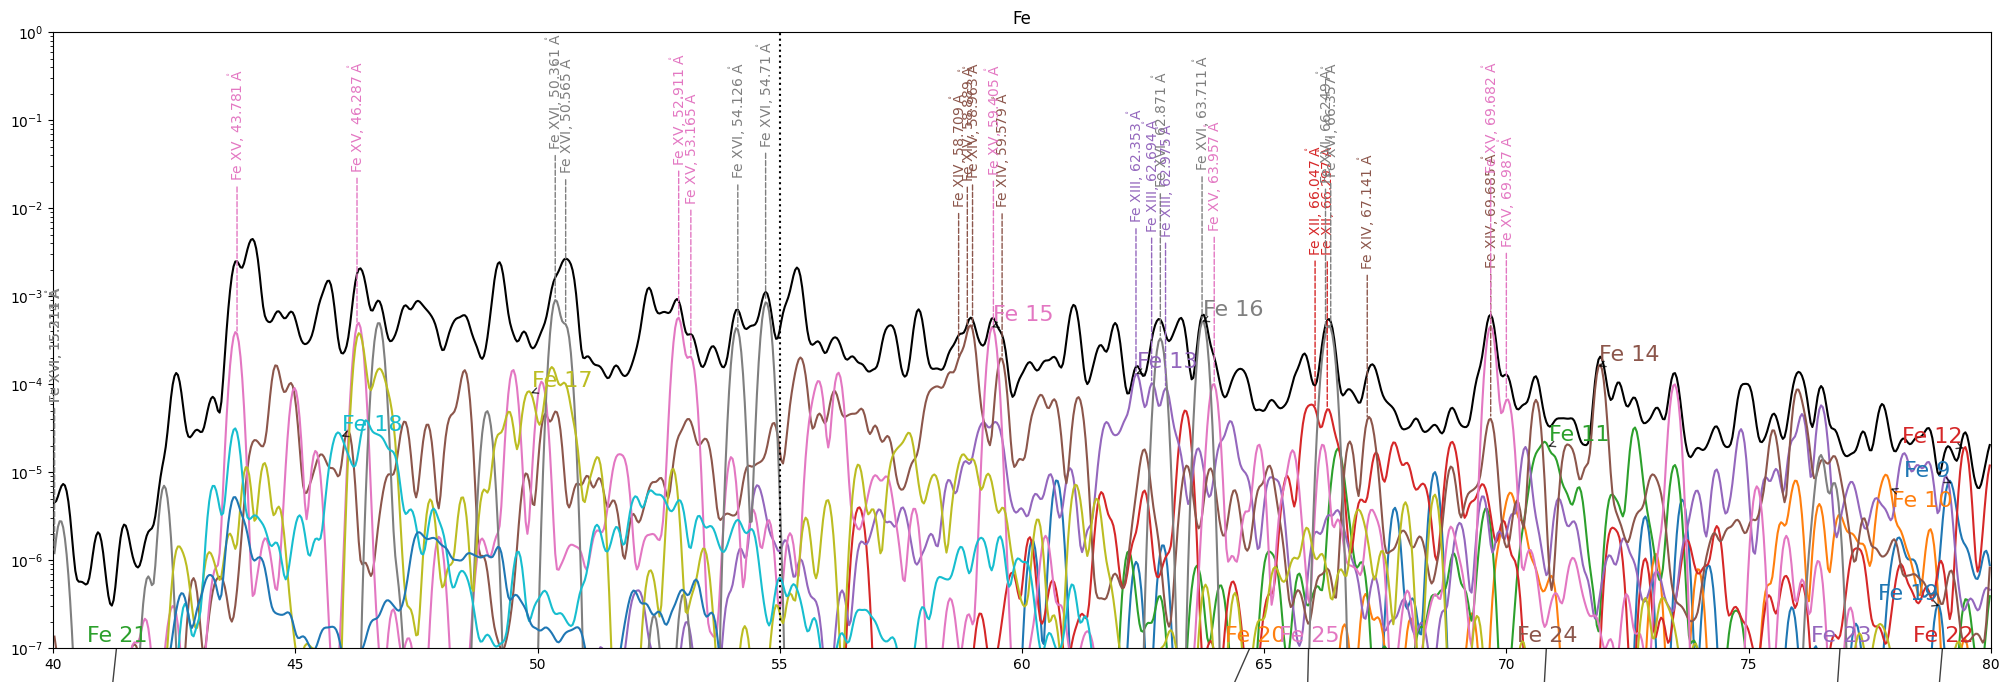

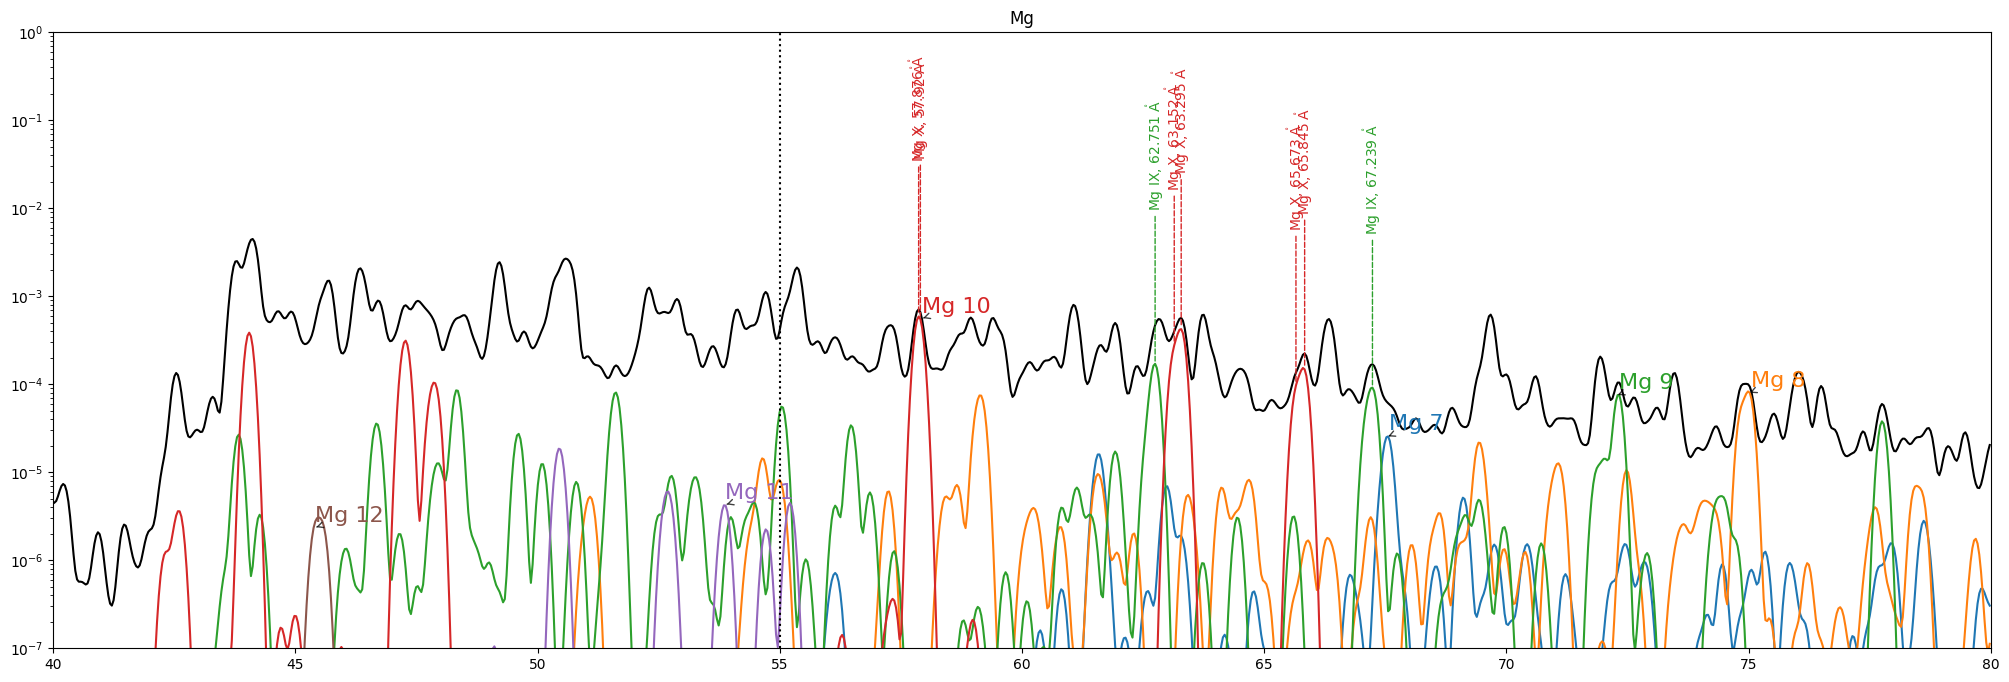

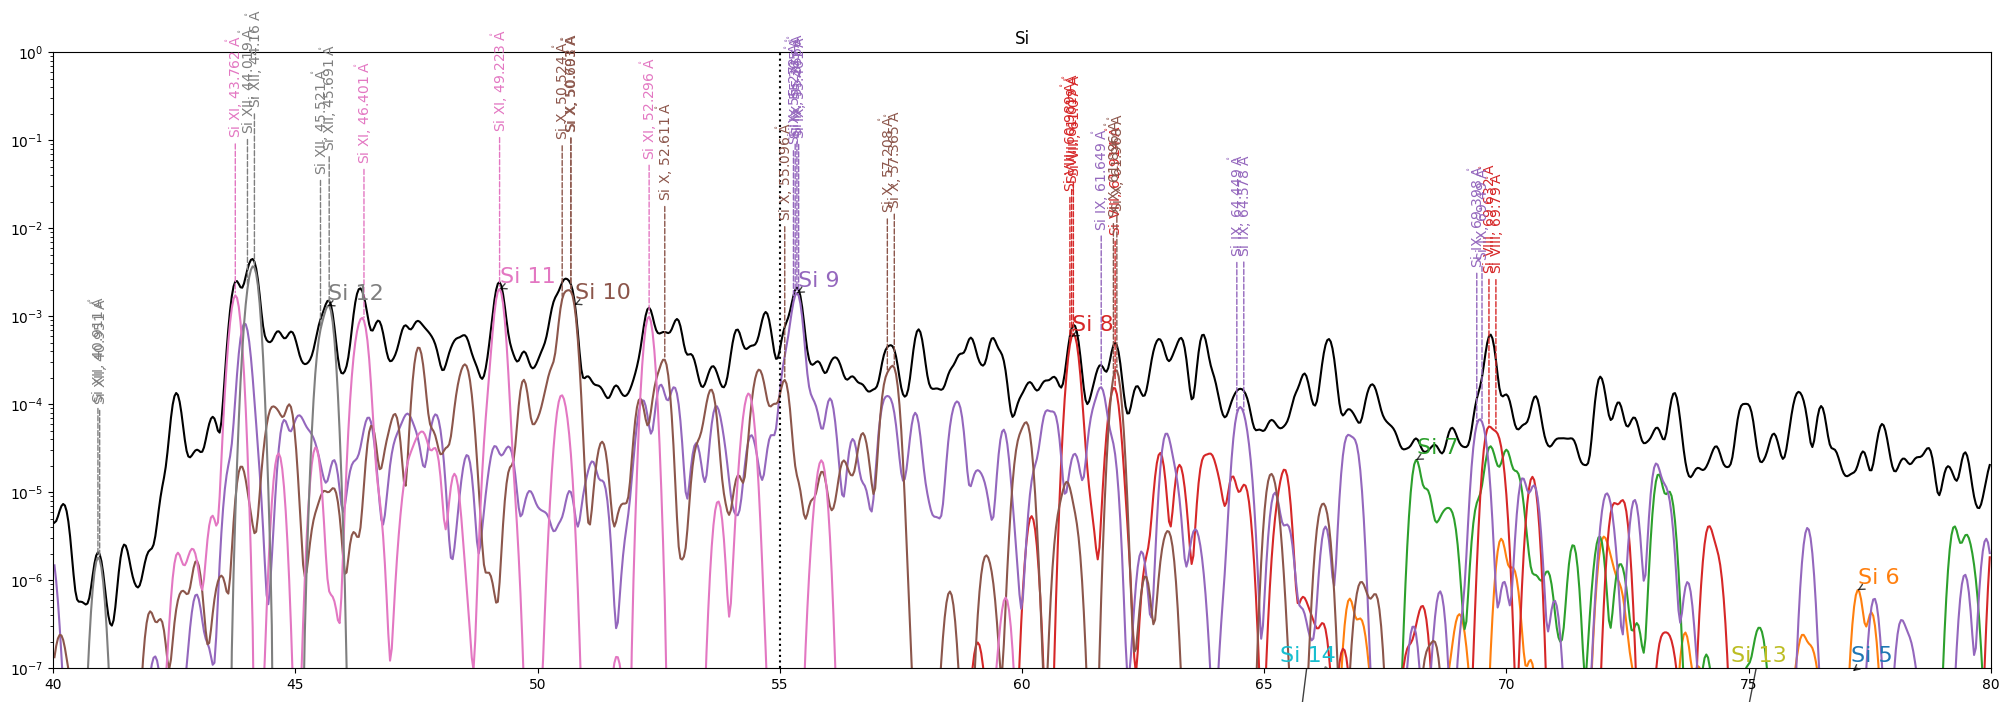

In [76]:
elements_unique = sorted(set(map(lambda x: x.split('_')[0], list(flux_ar.keys()))))
wave_grid = flux_ar_total['total'].axis_world_coords()[0]
wave_min = 40 * u.AA
wave_max = 80 * u.AA
i_wave_range = np.where(np.logical_and(wave_grid>wave_min, wave_grid<wave_max))
thresh = 0.00
for el in ['fe', 'mg', 'si']:#'ni', 's', 'si']:
    fig = plt.figure(figsize=(25,8))
    ax = fig.add_subplot(111)
    ax.plot(wave_grid[i_wave_range], flux_ar_total['total'].data[i_wave_range], color='k')
    line_labels = []
    for k,v in flux_ar.items():
        if el == k.split('_')[0].lower():
            ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range] 
            if (ratio > thresh)[:].any():
                ion_label = ' '.join(k.split('_')).capitalize()
                l, = ax.plot(wave_grid[i_wave_range], v['total'].data[i_wave_range], label=ion_label)
                line_labels.append(ax.text(wave_grid[i_wave_range][np.nanargmax(ratio)].to_value(), 
                                           v['total'].data[i_wave_range][np.nanargmax(ratio)],
                                           ion_label,
                                           color=l.get_color(),
                                           fontsize=16))
                annotate_lines(ax,
                               line_list_reduced[line_list_reduced['ion id'] == k],
                               wave_grid[i_wave_range],
                               v['total'].data[i_wave_range], l.get_color(),
                               rtol=0.05)
    ax.axvline(x=55, color='k', ls=':',)
    ax.set_yscale('log')
    ax.set_ylim(1e-7,1)
    ax.set_xlim(wave_min.to_value(), wave_max.to_value())
    # ax.legend(ncol=10, loc=1)
    ax.set_title(el.capitalize())
    if line_labels:
        adjust_text(
            line_labels,
            x=[l.get_position()[0] for l in line_labels],
            y=[l.get_position()[1] for l in line_labels],
            #avoid_points=True,
            #avoid_text=True,
            #avoid_self=True,
            arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
            clip_on=True,
        )

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_67718/4176228255.py:14: RuntimeWarning: invalid value encountered in divide
  ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range]


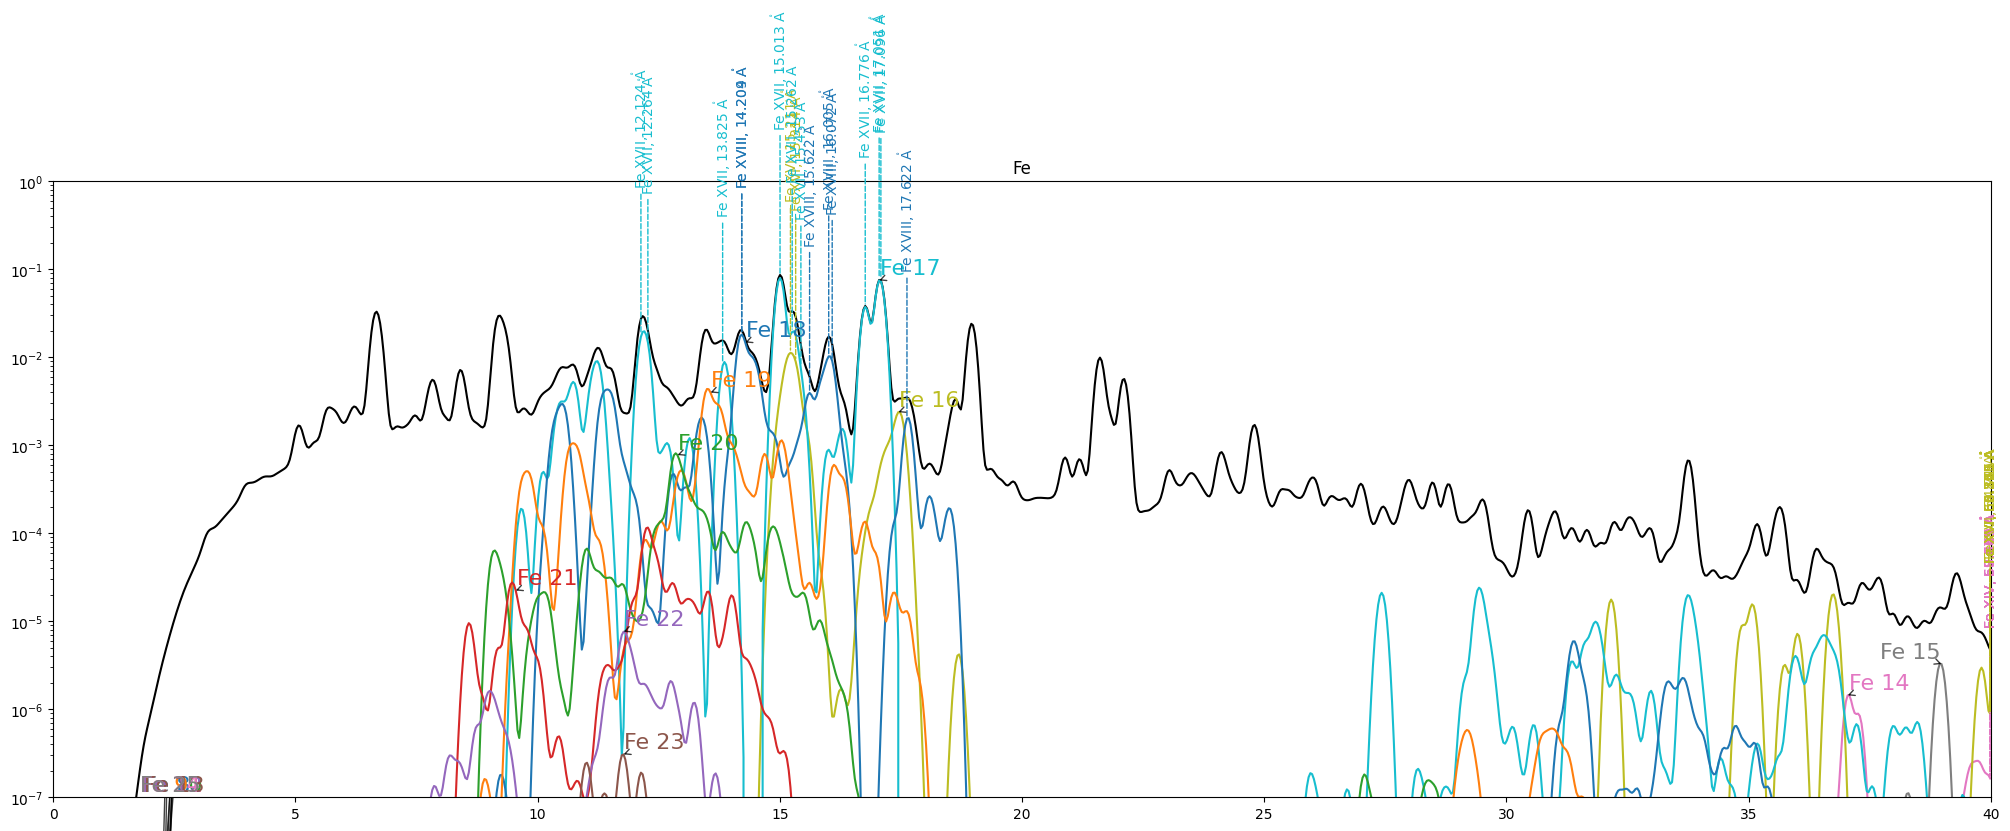

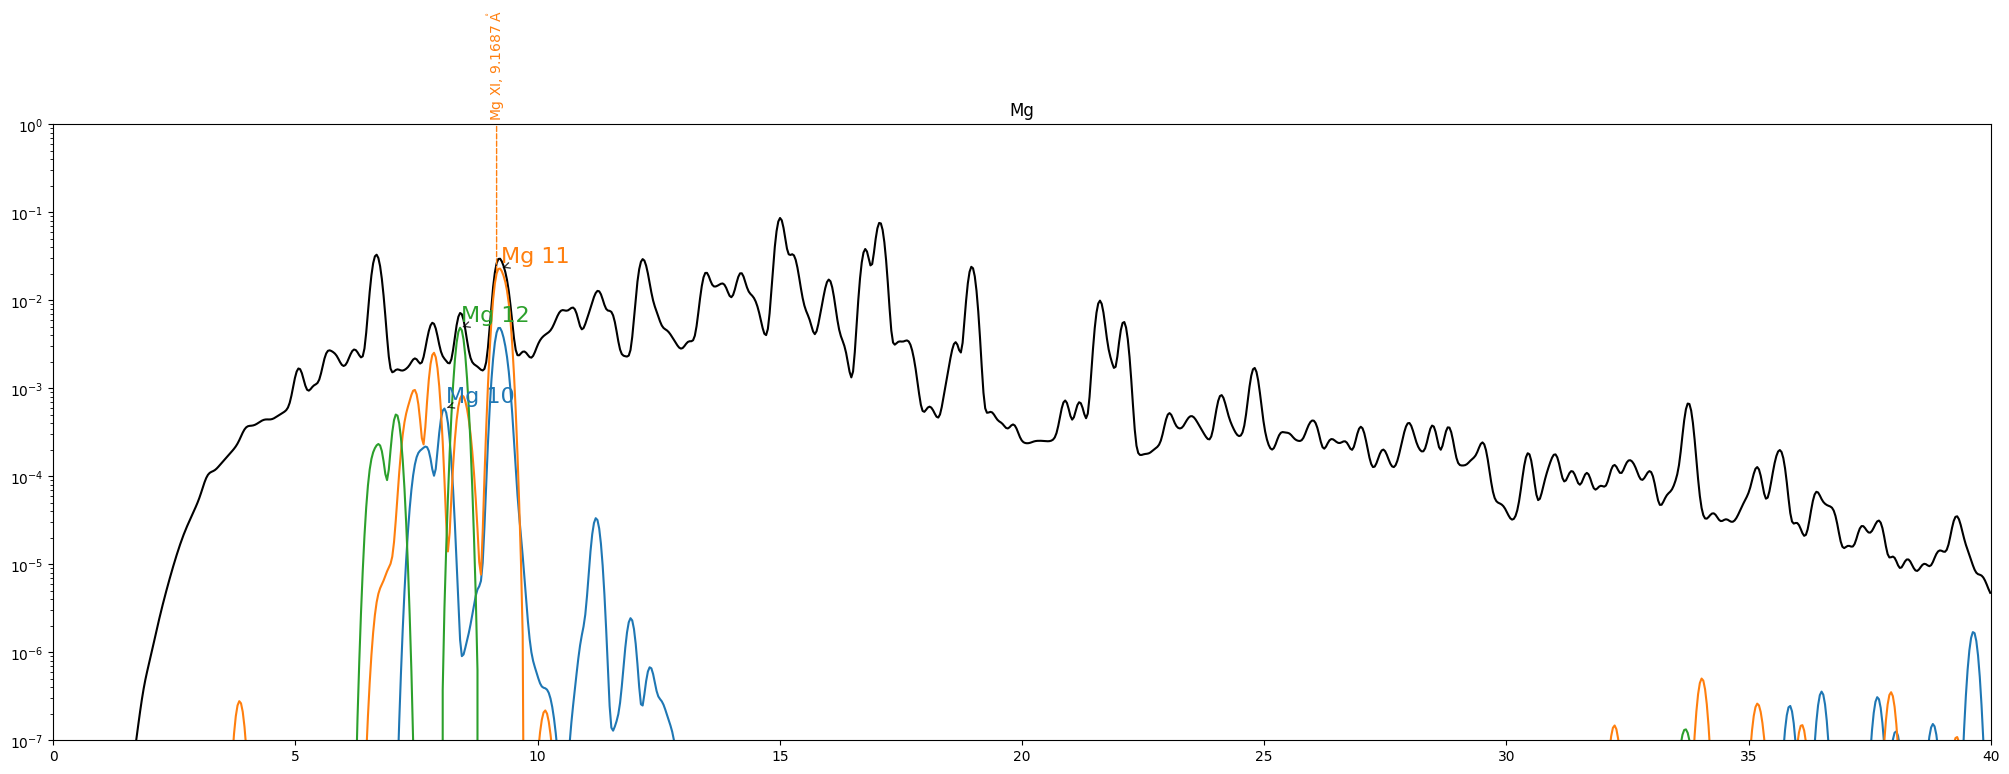

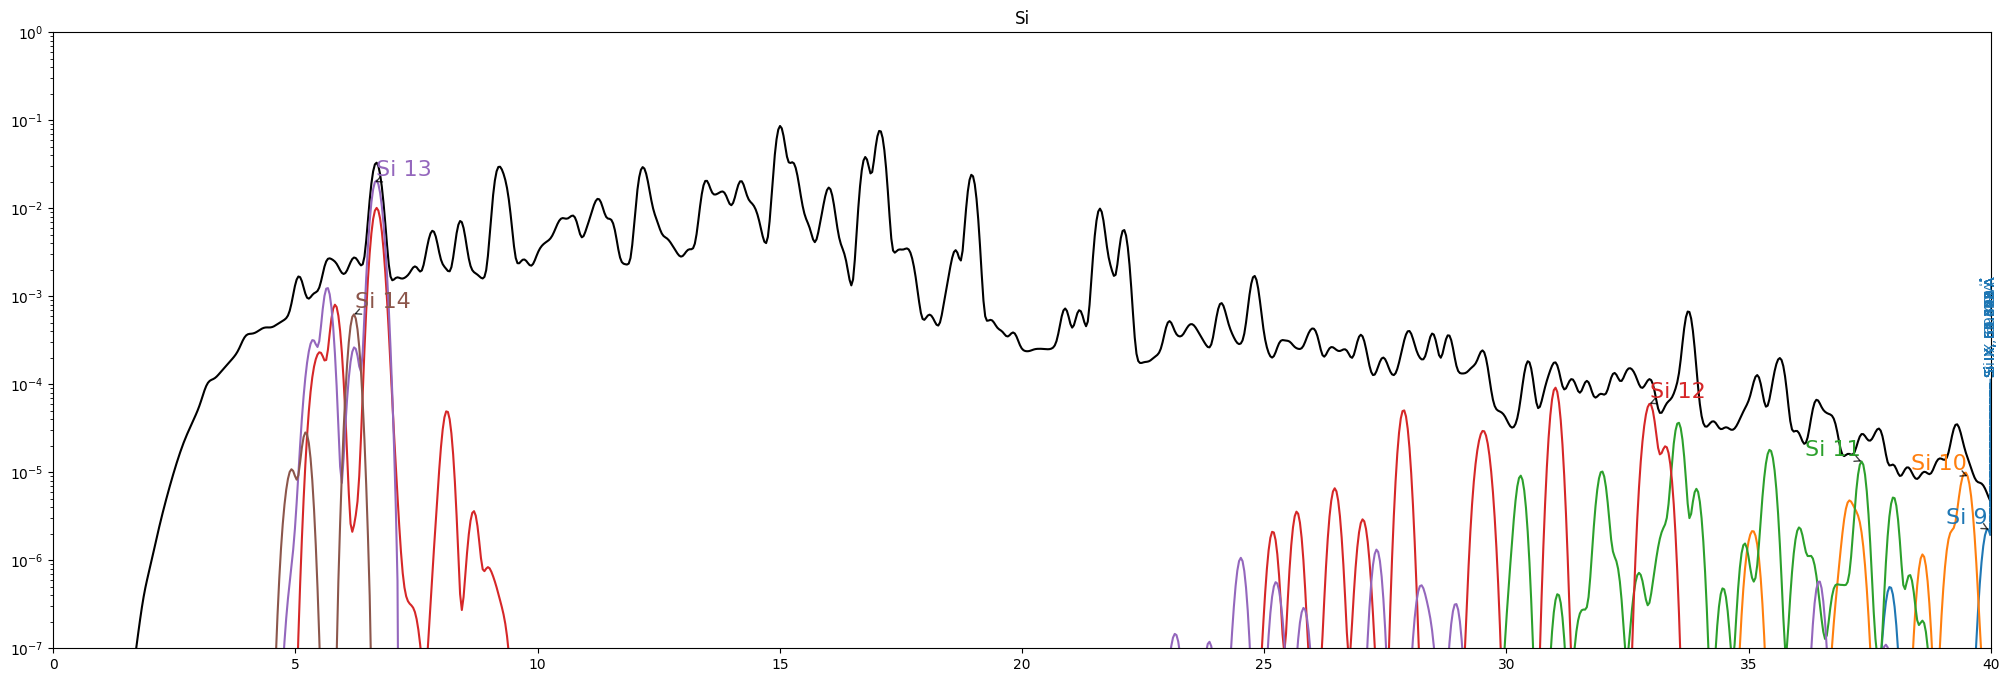

In [77]:
elements_unique = sorted(set(map(lambda x: x.split('_')[0], list(flux_ar.keys()))))
wave_grid = flux_ar_total['total'].axis_world_coords()[0]
wave_min = 0 * u.AA
wave_max = 40 * u.AA
i_wave_range = np.where(np.logical_and(wave_grid>wave_min, wave_grid<wave_max))
thresh = 0.00
for el in ['fe', 'mg', 'si']:#'ni', 's', 'si']:
    fig = plt.figure(figsize=(25,8))
    ax = fig.add_subplot(111)
    ax.plot(wave_grid[i_wave_range], flux_ar_total['total'].data[i_wave_range], color='k')
    line_labels = []
    for k,v in flux_ar.items():
        if el == k.split('_')[0].lower():
            ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range] 
            if (ratio > thresh)[:].any():
                ion_label = ' '.join(k.split('_')).capitalize()
                l, = ax.plot(wave_grid[i_wave_range], v['total'].data[i_wave_range], label=ion_label)
                line_labels.append(ax.text(wave_grid[i_wave_range][np.nanargmax(ratio)].to_value(), 
                                           v['total'].data[i_wave_range][np.nanargmax(ratio)],
                                           ion_label,
                                           color=l.get_color(),
                                           fontsize=16))
                annotate_lines(ax,
                               line_list_reduced[line_list_reduced['ion id'] == k],
                               wave_grid[i_wave_range],
                               v['total'].data[i_wave_range], l.get_color(),
                               rtol=0.05)
    ax.axvline(x=55, color='k', ls=':',)
    ax.set_yscale('log')
    ax.set_ylim(1e-7,1)
    ax.set_xlim(wave_min.to_value(), wave_max.to_value())
    # ax.legend(ncol=10, loc=1)
    ax.set_title(el.capitalize())
    if line_labels:
        adjust_text(
            line_labels,
            x=[l.get_position()[0] for l in line_labels],
            y=[l.get_position()[1] for l in line_labels],
            #avoid_points=True,
            #avoid_text=True,
            #avoid_self=True,
            arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
            clip_on=True,
        )

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_67718/3786876980.py:9: RuntimeWarning: invalid value encountered in divide
  ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range]


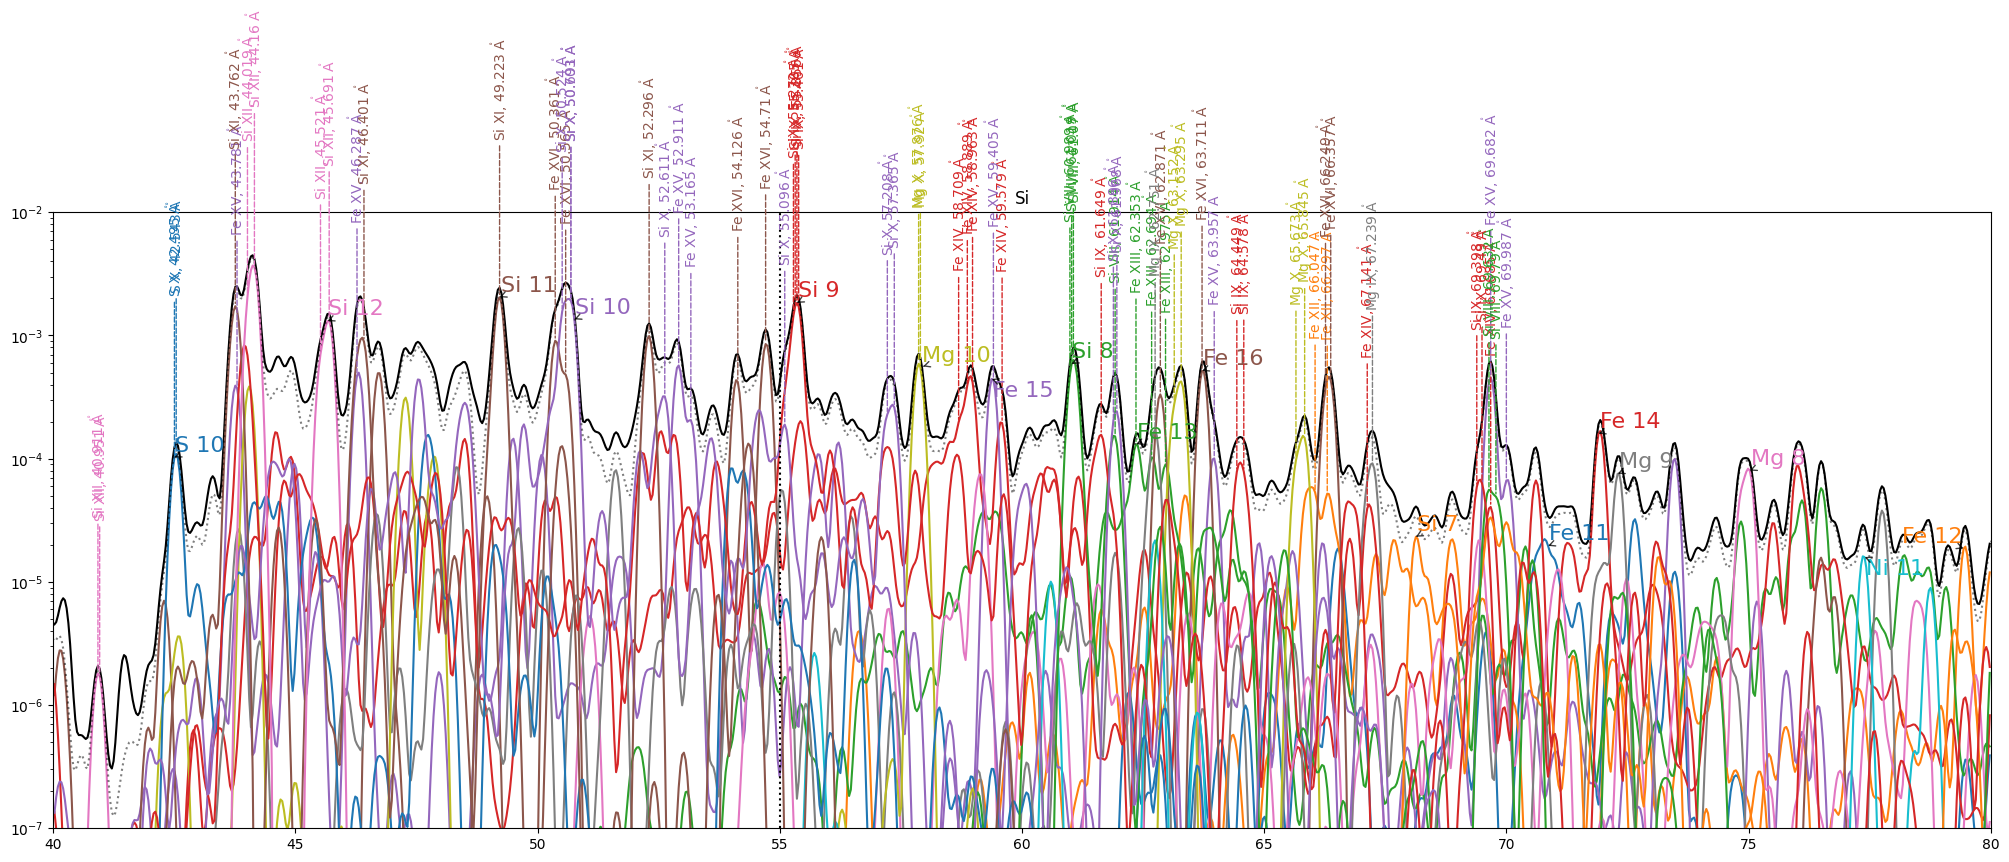

In [69]:
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(111)
ax.plot(wave_grid[i_wave_range], flux_ar_total['total'].data[i_wave_range], color='k')
line_labels = []
tot = np.zeros(wave_grid.shape)
for el in ['fe', 'mg', 'ni', 's', 'si']:#elements_unique:
    for k,v in flux_ar.items():
        if el == k.split('_')[0].lower():
            ratio = (v['total'].data / flux_ar_total['total'].data)[i_wave_range]
            if (ratio > 0.5)[:].any():
                ion_label = ' '.join(k.split('_')).capitalize()
                l, = ax.plot(wave_grid[i_wave_range], v['total'].data[i_wave_range], label=ion_label,)
                line_labels.append(ax.text(wave_grid[i_wave_range][np.nanargmax(ratio)].to_value(), 
                                           v['total'].data[i_wave_range][np.nanargmax(ratio)],
                                           ion_label,
                                           color=l.get_color(),
                                           fontsize=16))
                annotate_lines(ax,
                               line_list_reduced[line_list_reduced['ion id'] == k],
                               wave_grid[i_wave_range],
                               v['total'].data[i_wave_range], l.get_color(),
                               rtol=0.05)
            tot += v['total'].data
ax.plot(wave_grid, tot, color='k', ls=':', alpha=0.5)
ax.axvline(x=55, color='k', ls=':',)    
ax.set_yscale('log')
ax.set_ylim(1e-7,1e-2)
ax.set_xlim(40,80)
#ax.legend(ncol=20, loc=1, frameon=False)
ax.set_title(el.capitalize())
if line_labels:
    adjust_text(
        line_labels,
        x=[l.get_position()[0] for l in line_labels],
        y=[l.get_position()[1] for l in line_labels],
        #avoid_points=True,
        #avoid_text=True,
        #avoid_self=True,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
        clip_on=True,
    )

What's the relevant temperature sensitivity of all of these ions?

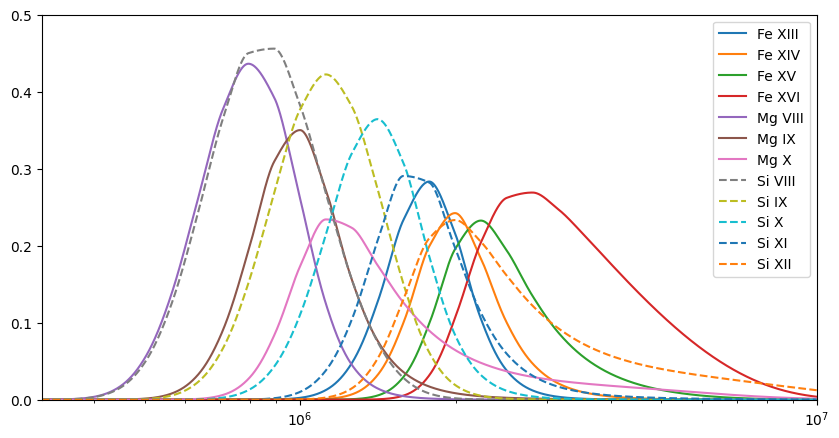

In [180]:
temperature = np.logspace(5.5,7,10000) * u.K
cool_ions = fiasco.IonCollection(*[
    fiasco.Ion(_ion, temperature) for _ion in 
    ['Fe 13', 'Fe 14', 'Fe 15', 'Fe 16', 'Mg 8', 'Mg 9', 'Mg 10', 'Si 8', 'Si 9', 'Si 10', 'Si 11', 'Si 12']
])
plt.figure(figsize=(10,5))
for ion in cool_ions:
    plt.plot(ion.temperature, ion.ioneq, label=ion.ion_name_roman, ls='--' if ion.atomic_symbol=='Si' else '-')
plt.xscale('log')
plt.xlim(temperature[[0,-1]].value)
plt.ylim(0,0.5)
plt.legend()

What about actual lines?

Text(192.09722222222223, 0.5, 'Effective Formation Temperature [MK]')

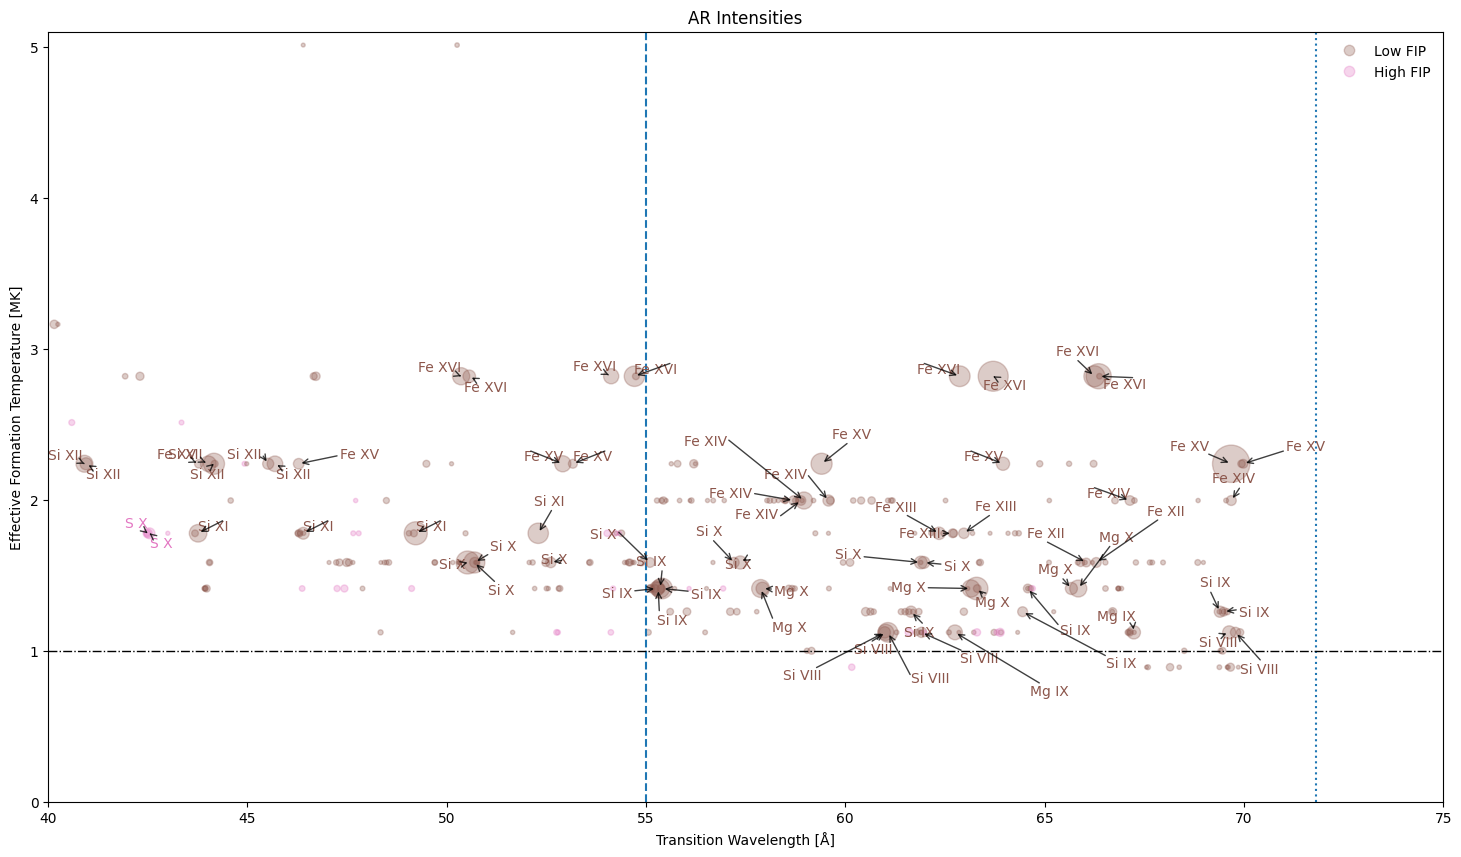

In [202]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
low_fip_color = 'C5'
high_fip_color = 'C6'
with quantity_support():
    ax.scatter(line_list_reduced['wavelength'],
               line_list_reduced['max temperature_active_region'].to('MK'),
               s=line_list_reduced['intensity_scaled (coronal)_active_region']*3e3,
               marker='.', alpha=0.3, color=[low_fip_color if r['is low FIP'] else high_fip_color for r in line_list_reduced])
    for ls,spec_res in zip(['--', ':'], [55, 71.8] * u.milliAA / u.pix):
        max_wave = 1000 * u.pix * spec_res
        for i,order in enumerate([1,2,3,4]):
            ax.axvline(x=max_wave/order, ls=ls, color=f'C{i}')
    ax.axhline(y=1*u.MK, ls='-.', color='k', lw=1)
    ax.axhline(y=10*u.MK, ls='-.', color='k', lw=1)
    
    line_labels = []
    line_label_tol = 0.05
    for row in line_list_reduced:
        if row['intensity_scaled (coronal)_active_region'] >= line_label_tol:
            line_labels.append(ax.text(row['wavelength'], row['max temperature_active_region'], row['ion name'],
                                       color=low_fip_color if row['is low FIP'] else high_fip_color))
    adjust_text(
        line_labels,
        x=copy.deepcopy(line_list_reduced['wavelength'].to_value('AA')),
        y=copy.deepcopy(line_list_reduced['max temperature_active_region'].to_value('MK')),
        avoid_points=False,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
    )
    #ax.set_yscale('log')
    ax.set_ylim(0,5.1)
    ax.set_xlim(40,75)
    ax.set_title('AR Intensities')
    ax.legend(handles=[plt.Line2D([0], [0], marker='.', color=low_fip_color, label='Low FIP', ls='', alpha=0.3, markersize=15),
                       plt.Line2D([0], [0], marker='.', color=high_fip_color, label='High FIP', ls='', alpha=0.3, markersize=15)],
              loc=1, frameon=False)
ax.set_xlabel(r'Transition Wavelength [Å]')
ax.set_ylabel(r'Effective Formation Temperature [MK]')

In [34]:
fe_mg_si_line_list = line_list_reduced[list(map(lambda x: x in ('Fe', 'Mg', 'Si', 'S'), line_list_reduced['element']))]
fe_mg_si_line_list = fe_mg_si_line_list[fe_mg_si_line_list['intensity_scaled (coronal)_active_region']>0.05]
ion_names_unique = np.unique(fe_mg_si_line_list['ion name'])
contribution_functions = {}
for ion_name in ion_names_unique:
    print(ion_name)
    ion = fiasco.Ion(ion_name, 10**np.arange(5,7,0.05)*u.K)
    goft = ion.contribution_function(1e9*u.cm**(-3))
    transitions = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    contribution_functions[ion_name] = (transitions, goft)

Fe XII
Fe XIII
Fe XIV
Fe XV
Fe XVI


Mg IX
Mg X


S X
Si IX
Si VIII
Si X
Si XI
Si XII


In [35]:
goft_col = []
for row in fe_mg_si_line_list:
    _t, _g = contribution_functions[row['ion name']]
    idx = np.argmin(np.abs(_t - row['wavelength']))
    goft_col.append(_g[:,0,idx])
fe_mg_si_line_list['contribution function'] = u.Quantity(goft_col)

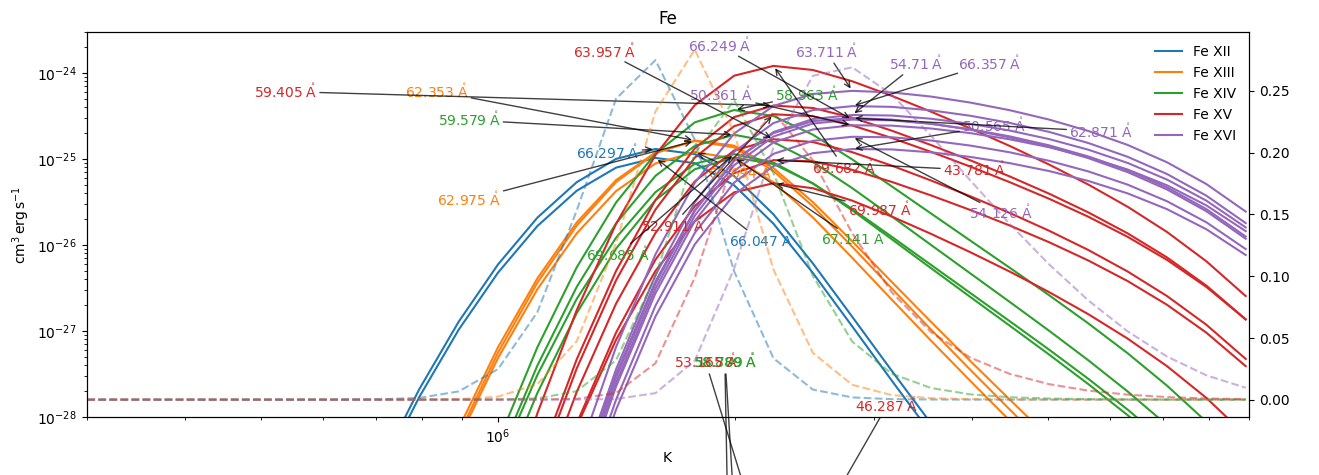

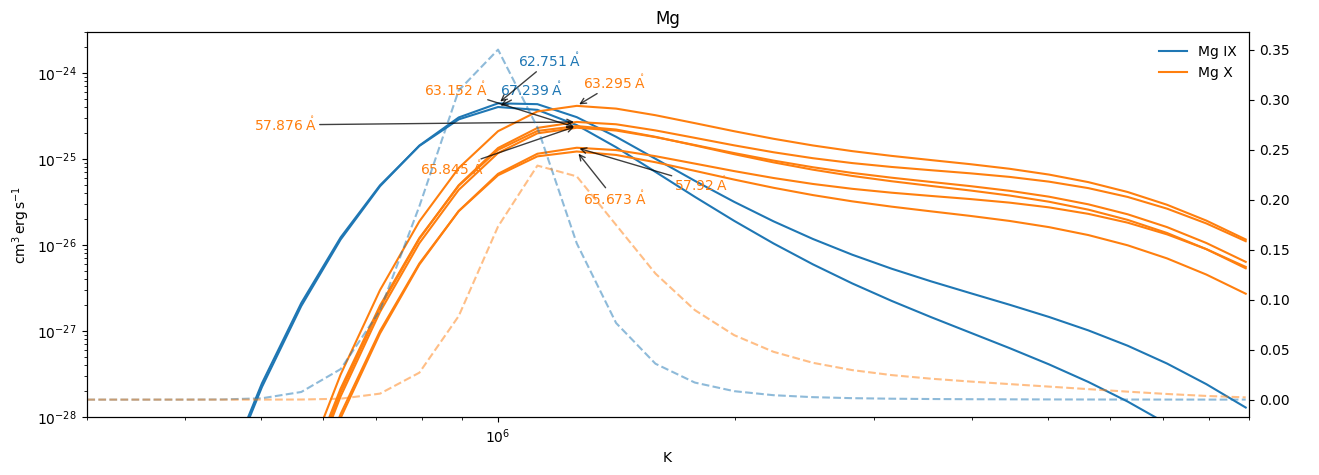

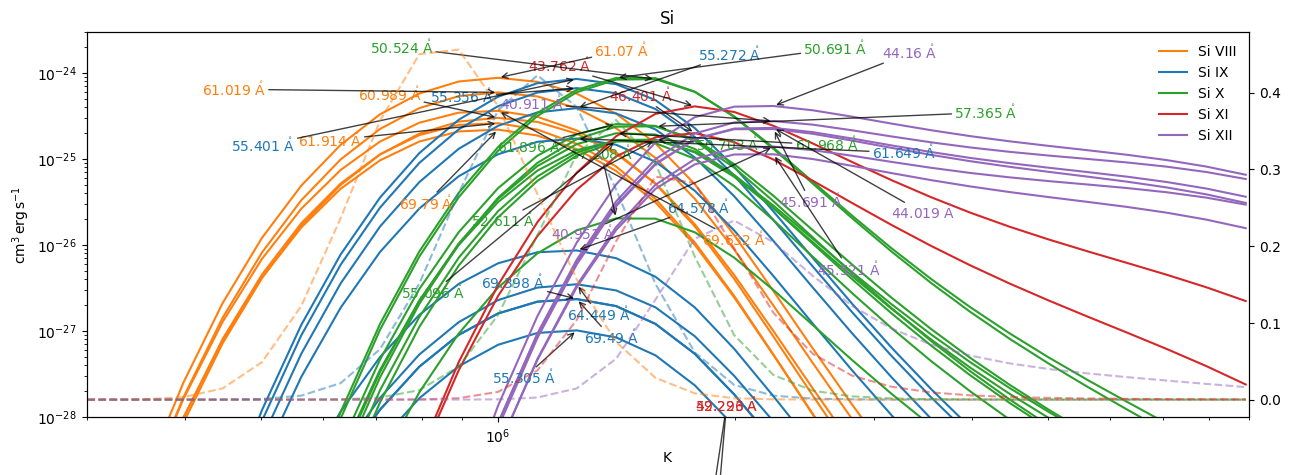

In [61]:
with quantity_support():
    for el in ['Fe', 'Mg', 'Si']:
        fig = plt.figure(figsize=(15,5))
        ax = fig.add_subplot()
        _tab = fe_mg_si_line_list[fe_mg_si_line_list['element']==el]
        colors = {_i: f'C{i}' for i,_i in enumerate(np.unique(_tab['ion name']))}
        annotations = []
        for row in _tab:
            ax.plot(ion.temperature, row['contribution function'], color=colors[row['ion name']], label=row['ion name'])
            annot = ax.text(
                ion.temperature[row['contribution function'].argmax()],
                row['contribution function'].max(),
                f'{row["wavelength"].to_string(format="latex_inline", precision=5)}',
                color=colors[row['ion name']],
                ha='center',
                va='center',
            )
            annotations.append(annot)
        ax2 = ax.twinx()
        for _i in np.unique(_tab['ion name']):
            __i = fiasco.Ion(_i, ion.temperature)
            ax2.plot(__i.temperature, __i.ioneq, color=colors[_i], ls='--', alpha=0.5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1e-28,3e-24)
        ax.set_xlim(3e5,.9e7)
        ax.set_title(el)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), frameon=False)
        adjust_text(
            annotations,
            ax=ax,
            x=[l.get_position()[0].value for l in annotations],
            y=[l.get_position()[1].value for l in annotations],
            avoid_points=True,
            avoid_text=True,
            avoid_self=False,
            arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
            clip_on=True,
            force_text=(1.5,2),
            force_points=(1,1),
        )

## Sandbox

Comparing spectral tables to figure out what is going on with component-wise sums

In [39]:
spec_full = read_spectral_table('/Users/wtbarnes/Desktop/test-spectra/chianti-spectrum-coronal-full.asdf')
spec_no_continuum_all_ions = read_spectral_table('/Users/wtbarnes/Desktop/test-spectra/chianti-spectrum-coronal.asdf')
spec_only_fe = read_spectral_table('/Users/wtbarnes/Desktop/test-spectra-again/chianti-spectrum-coronal.asdf')

In [19]:
spec_components_fe = [read_spectral_table(f) for f in
                      sorted(pathlib.Path('/Users/wtbarnes/Desktop/test-spectra-again/').glob('chianti-spectrum-fe_*.asdf'))]
spec_component_sum_fe = ndcube.NDCube(
    np.array([sc.data for sc in spec_components_fe]).sum(axis=0),
    wcs=spec_components_fe[0].wcs,
    unit=spec_components_fe[0].unit,
)

In [41]:
component_files = sorted(pathlib.Path('/Users/wtbarnes/Desktop/test-spectra/').glob('chianti-spectrum-*_*.asdf'))
spec_components = [read_spectral_table(f) for f in component_files]
#spec_component_sum = ndcube.NDCube(np.zeros(spec_components[0].data.shape), spec_components[0].wcs, unit=spec_components[0].unit)
#for sc in spec_components:
#    el_name = sc.meta['ion_list'][0].split('_')[0].capitalize()
#    abund = abundance_table[abundance_table['element']==el_name]['abundance']
#    spec_component_sum = spec_component_sum + sc.data*sc.unit*abund
spec_component_sum = ndcube.NDCube(
    np.array([sc.data*abundance_table[abundance_table['element']==sc.meta['ion_list'][0].split('_')[0].capitalize()]['abundance']
              for sc in spec_components]).sum(axis=0),
    wcs=spec_components[0].wcs,
    unit=spec_components[0].unit,
)

First, subtract the full calculation from the calculation that does not include the continuum and that explicitly denotes the list of ions to be used. This should yield only the continuum

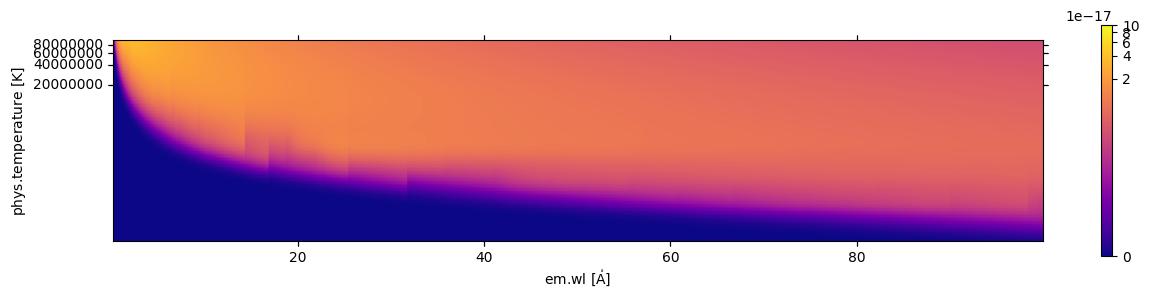

In [42]:
spec_diff = spec_full - spec_no_continuum_all_ions.data*spec_no_continuum_all_ions.unit

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(projection=spec_diff.wcs)
spec_diff.plot(aspect=10,axes=ax,norm=ImageNormalize(vmax=1e-16,stretch=LogStretch()), cmap='plasma')
fig.colorbar(ax.get_images()[0])

Now, subtract the component-wise sum from the explicit list case with no continuum. This should be zero.

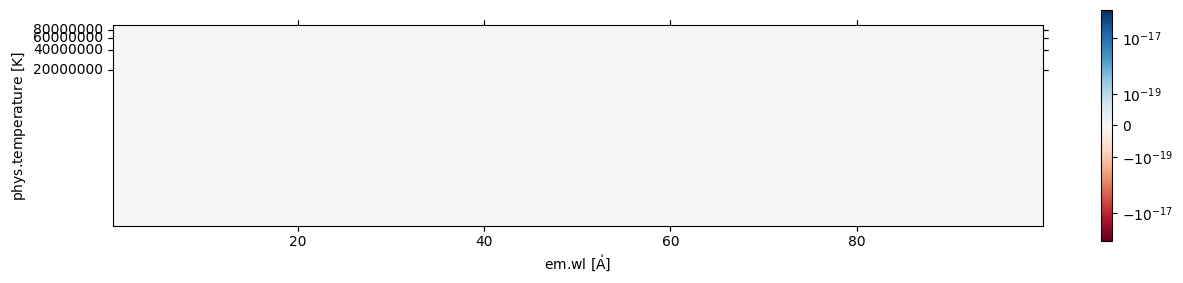

In [43]:
spec_diff = spec_no_continuum_all_ions - spec_component_sum.data*spec_component_sum.unit

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(projection=spec_diff.wcs)
spec_diff.plot(aspect=10,axes=ax, cmap='RdBu', norm=matplotlib.colors.SymLogNorm(1e-19, vmin=-1e-16, vmax=1e-16))
fig.colorbar(ax.get_images()[0])

Subtract the calculation that explicitly includes all Fe ions from the sum of all Fe components, this time not weighted by the abundance since the abundance is explicitly included in the original calculation.

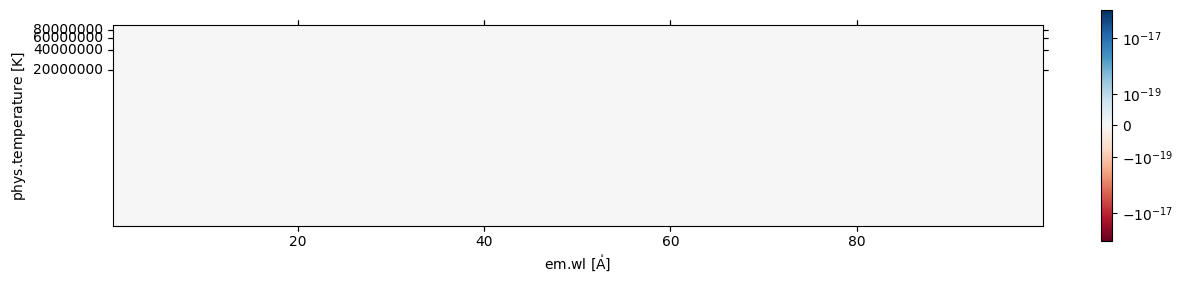

In [23]:
spec_diff = spec_only_fe - spec_component_sum_fe.data*spec_component_sum_fe.unit

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(projection=spec_diff.wcs)
spec_diff.plot(aspect=10,axes=ax, cmap='RdBu', norm=matplotlib.colors.SymLogNorm(1e-19, vmin=-1e-16, vmax=1e-16))
fig.colorbar(ax.get_images()[0])

In [28]:
spec_diff.data

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.59177481e-41,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [36]:
abundance_table

<QTable length=30>
  Z         abundance        element
                                    
int64        float64           str2 
----- ---------------------- -------
    1                    1.0       H
    2    0.07943282347242822      He
    3 4.3651583224016655e-11      Li
    4  8.709635899560797e-11      Be
    5 1.2302687708123811e-09       B
    6  0.0003890451449942805       C
    7                 0.0001       N
    8  0.0007762471166286928       O
    9   3.63078054770101e-08       F
   10 0.00012022644346174131      Ne
   11   8.51138038202376e-06      Na
   12 0.00014125375446227554      Mg
   13 1.0964781961431852e-05      Al
   14  0.0001258925411794166      Si
   15  2.818382931264455e-07       P
   16 1.8620871366628657e-05       S
   17  3.162277660168379e-07      Cl
   18  3.801893963205613e-06      Ar
   19  4.677351412871981e-07       K
   20   8.51138038202376e-06      Ca
   21  5.128613839913658e-09      Sc
   22   3.63078054770101e-07      Ti
   23 3.4673685045253164e-08       V
   24 1.6218100973589298e-06      Cr
   25  8.511380382023759e-07      Mn
   26  0.0001258925411794166      Fe
   27 2.8840315031266057e-07      Co
   28 6.9183097091893625e-06      Ni
   29 5.6234132519034905e-08      Cu
   30  1.380384264602884e-07      Zn